## Figure 2: Show experimental data on activity of 4 spider species and compare FRP for different those species

### import modules

In [1]:
#----------------------------------------------------------
# Import important libraries
#----------------------------------------------------------
import pandas  as pd
import numpy   as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp
sns.set()

##  Panel A: Plot summary for total activity in LD

### Essential functions

In [2]:
def hourly_mean_graph(filename):
    # import data frame
    df = pd.read_csv(filename, index_col='Date-Time', parse_dates=True)
    # Find ligth of and off times
    light_off = light_time(df)
    # Group by hour - sum total hourly activity
    df['hour'] = df.index.hour
    df_by_hour = df.groupby([df['hour']]).sum()
    df_by_hour.drop(columns=['Light'], inplace = True)
    df_by_hour['mean'] = df_by_hour.mean(axis=1)
    # plot activity as a bar graph
    make_bar_graph(df_by_hour, light_off)
    return()

#   Find times when the lights was turned on or off
def light_time(df):
    #   this is times when the ligaht is changes from 0 to 1 or difference between two time points is negative 
    switch = df.index[df.Light.diff()<0]
    # For the daily time of light off, use the hour of the swith signal
    light_off = switch.hour[0]
    # Find date and time for the last time switch
    last_light = switch[-1]
    return(light_off)


def change_to_zt(hours, light_off):
    shift = light_off - 12
    zt = np.zeros(len(hours))
    for i in range(0, len(hours)):
        zt[i] = hours[i] - shift
        if zt[i]<0:
            zt[i] = zt[i]+24
    return(zt)

def make_bar_graph(df_by_hour, light_off):
    plt.style.use('ggplot')
    df_by_hour['zt'] = change_to_zt(df_by_hour.index, light_off)
    plt.bar(df_by_hour['zt'], df_by_hour['mean'], color = 'k')
    
    plt.ylabel('Average activity')
    plt.axvspan(11.5, 23.5,ymin=0., ymax=5, alpha=0.5, color='grey')
    plt.xlim(-0.5,23.5)
    ax = plt.gca()
    ax.set_facecolor('white')
    # Hide grid lines
    ax.grid(False)

## Make subplot with activity for each spider specie

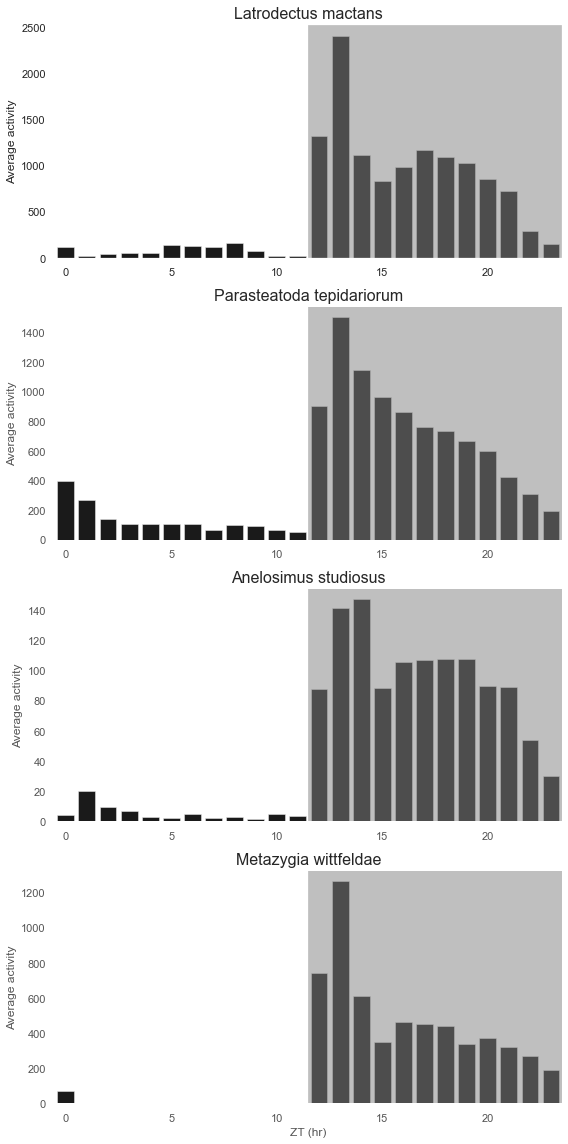

In [3]:
fig1=plt.figure(figsize=(8,16))

info = pd.read_csv('spider_activity_metafile.csv')

#plt.subplots_adjust(left = 0.1, hspace = 0.55)
n_subplots = len(info.index)
for i in info.index:
    current_subplot = i+1
    plt.subplot(n_subplots, 1, current_subplot)
    hourly_mean_graph(info.File.loc[i])
    plt.title(info.Specie.loc[i], fontsize=16)
plt.xlabel('ZT (hr)')
plt.tight_layout()
plt.savefig('Figure2_Activity_LD.jpeg', transparent=True, dpi = 300)

### support functions for raster plots

In [4]:
# for working with datetime
from datetime import timedelta
import datetime as dt

#---------------------------------------------------------------------
# Download experimental recording using monitor name and extract activity into a data frame with date-time index
#---------------------------------------------------------------------
def import_activity(filename):
    # For L. mactan use tabulated input
    df = pd.read_csv(filename, header = 0, index_col = 0, parse_dates=True)
    # Convert index into date-time
    #df["Date-Time"] = pd.to_datetime(df.Date + ' ' + df.Time)
    #df = df.set_index("Date-Time")
    df['Date'] = df.index.date
    df['Time'] = df.index.time
    return(df)

#---------------------------------------------------------------------
#  Reduce duration of the activity to a given range of dates
#---------------------------------------------------------------------
def cut_off_dates(df, start_date, end_date):
    after_start_date = df.index >= start_date
    before_end_date = df.index <= end_date
    df_reduced = df[after_start_date & before_end_date]
    return(df_reduced)

#---------------------------------------------------------------------
#  Extract activity of single spider with given ID
#---------------------------------------------------------------------
def extract_one_spider(df, name):
    df1 = df[['Date', 'Time','Light',name]]
    df1 = df1.rename(columns = { name:'activity'})
    return(df1)

#---------------------------------------------------------------------
# Shade areas of the graph where light signal=0 (no light)
#---------------------------------------------------------------------
def shade_dark(df):
    light = df.index[df.Light ==1]
    if len(light)>0:
        plt.axvspan(df.index[0], light[0], alpha=0.5, color='grey')
        plt.axvspan( light[-1], df.index[-1],  alpha=0.5, color='grey')
    else:
        plt.axvspan(df.index[0], df.index[-1], alpha=0.5, color='grey')

#---------------------------------------------------------------------
# Make single raster plot for a given spider
#---------------------------------------------------------------------        
def make_raster(df, name, width, height):
    # Prepare grid with number of subplots equal number of days in the recordings
    days = df.Date.unique()
    nplots = len(days)
    plt.figure(figsize = (width, height))
    # Set up figure style to make it pretty
    sns.set_style("whitegrid", {'axes.grid' : False, 'axes.edgecolor': 'black',  'font.style': 'italic'})
    grid = plt.GridSpec(nrows = nplots, ncols = 1)
    plt.subplots_adjust(hspace = 0., wspace = 0)
    subplots = 1
    # Make a plot for every day
    for t in days[:-1]:
        # Extract data frame for a current day
        df_t = df[df.Date == t]
        ax1 = plt.subplot(grid[subplots-1, 0])
        df_t.plot( color = 'k', ax = ax1, legend=False)
        shade_dark(df_t)
        ax1.set_xticks([])
        ax1.set_xlabel('')
        ax1.set_yticks([])
        # label day number on every 4-th day
        if subplots % 4 == 0:
            ax1.set_ylabel(str(subplots), labelpad = 10, fontsize = 14) 
        subplots+=1
    # Label lowest x-axis
    ax1.set_xlabel("Time of day (hours)", fontsize = 16)
    filename = name+'.jpeg'
    plt.savefig(filename, dpi = 300 )
    return(filename)


## Make identical raster plots and save them as .jpeg

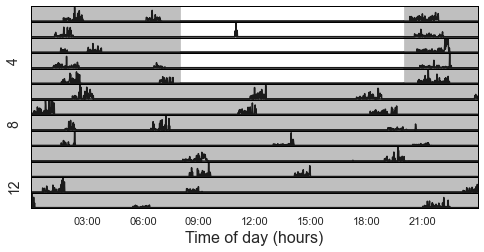

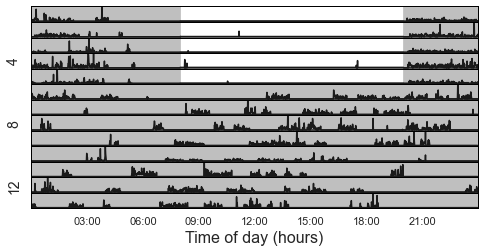

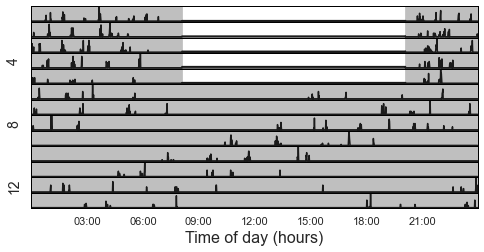

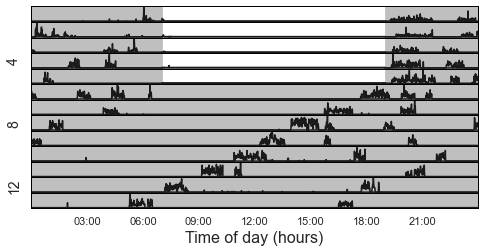

In [5]:
all_data  = pd.read_csv('raster_metadata.csv', index_col=0)
spiders = all_data.index
nplots = len(spiders)
subplot = 1
image_names = []
for ind in spiders:
    current_spider =  all_data.loc[ind, :]
    data_file  = current_spider.file
    spider_id  = current_spider.id
    start_date = current_spider.start
    end_date   = current_spider.end
    reresentative_spider = 'Monitor '+str(current_spider.monitor)+' Spider '+str(spider_id)
    df = extract_one_spider(import_activity(data_file), reresentative_spider)
    df_reduced  = cut_off_dates(df, start_date, end_date)
    image_names.append(make_raster(df_reduced, current_spider.file[:-4], 8, 4))

## Combine individual raster plots into single figure

In [18]:
import sys
from PIL import Image
#images = [Image.open(x) for x in ['Lactrodectus Mactans.jpeg', 'Metazygia Wittfeldae.jpeg']]
images = [Image.open(x) for x in image_names]
widths, heights = zip(*(i.size for i in images))

max_width = max(widths)
total_height = sum(heights)

new_im = Image.new('RGB', (max_width, total_height))

y_offset = 0
for im in images:
    new_im.paste(im, (0, y_offset))
    y_offset += im.size[1]

new_im.save('Figure2_rasters.jpeg',quality=95)

## Panel C:  Import periods of all spiders

### supporting function

In [9]:
# Function to plot identical pannels for LD and DD
def plot_pannel(df2, column):
    sns.boxplot  (y = 'specie', x=column, data=df2, showfliers = False)
    ax = sns.swarmplot(y = 'specie', x=column, data=df2, color = 'black', alpha = 0.5)
    for label in ax.get_yticklabels():
         label.set_style("italic")
    plt.xlabel('')
    plt.ylabel('')
    label= column[-2:]
    plt.title(label, fontsize=20, color = 'r')
    plt.xlim([14, 36])
    plt.xticks(np.arange(16, 37, 4))

## Plot periods by specie

C:\Users\robb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\robb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\robb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


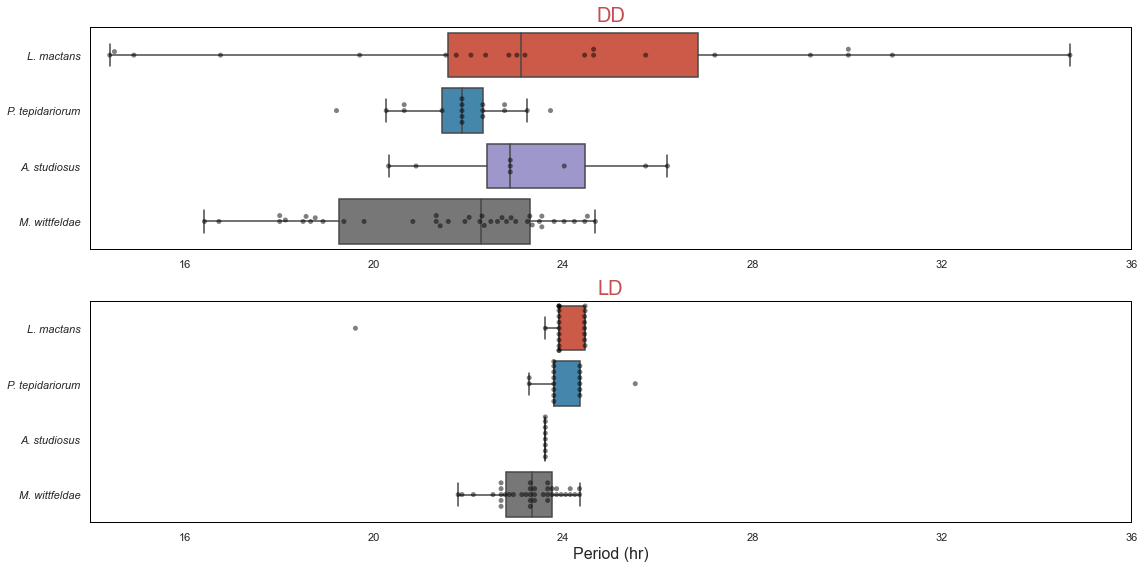

In [10]:
# Import data on periods in LD and DD
df2 = pd.read_csv('all_periods.csv',  header=0)

# Set up figure style to make it pretty
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.edgecolor': 'black',  'font.style': 'italic'})

# Make a figure for two subplots widely separated
plt.figure(figsize=(16,8))
#plt.subplots_adjust(hspace = 0.45, left= 0.23)

# Plot DD and LD on different subplots
plt.subplot(2,1,1)                  
plot_pannel(df2,'Period DD')
plt.subplot(2,1,2)
plot_pannel(df2,'Period LD')

# Lable x-axis only on the bottom pannel to aviod cluttering
plt.xlabel('Period (hr)',fontsize=16)

# Label figure pannels
#plt.text(7,-0.9,'B', fontsize=14, weight="bold")
#plt.text(7,-6.0,'A', fontsize=14, weight="bold")

plt.tight_layout()
plt.savefig('Figure2_periods.jpeg', dpi = 300)
plt.show()


In [28]:
from PIL import Image
image = Image.open('Figure2_Activity_LD.jpeg')
exif = image.info['exif']
image.save('image-test.jpeg' , exif=exif)

KeyError: 'exif'

### Combine activity and raster plot figures into one panel

In [27]:
import sys
from PIL import Image
panels = [Image.open(x) for x in ['Figure2_Activity_LD.jpeg', 'Figure2_rasters.jpeg']]
widths, heights = zip(*(i.size for i in panels))

panels[0].show()
#exif = panels[1].info['exif']

max_height = max(heights)
total_width = sum(widths)
print(total_width,max_height)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in panels:
    new_im.paste(im, (x_offset, 0))
    x_offset += im.size[0]

new_im.save('Figure2-top-panel-test.jpeg')

4800 4800


In [20]:
import sys
from PIL import Image
panels1 = [Image.open(x) for x in ['Figure2-top-panel-test.jpeg', 'Figure2_periods.jpeg']]
widths, heights = zip(*(i.size for i in panels1))

print('widths: ',widths)
print('heights: ',heights)

max_width = max(widths)
total_height = sum(heights)

new_im = Image.new('RGB', (max_width, total_height))

y_offset = 0
for im in panels1:
    new_im.paste(im, (0, y_offset))
    y_offset += im.size[1]

new_im.save('Figure2-all-panels.jpeg',quality=95)

widths:  (4800, 4800)
heights:  (4800, 2400)


### Add 'A','B' and 'C' labels to figure

In [21]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

mimage = Image.open('Figure2-all-panels.jpeg')

draw = ImageDraw.Draw(mimage)
font = ImageFont.truetype('arialbd', 78)
draw.text((37, 27),"A",fill = 'black', font = font)
draw.text((2437, 27),"B",fill = 'black', font = font)
draw.text((37, 4827),"C",fill = 'black', font = font)
mimage.save('Figure2.jpeg',quality=95)

## Calculate statistics for periods in LD and DD

In [16]:
def get_mean_and_sem(series):
    n = len(series)
    meam_series = np.mean(series)
    sem_series = np.std(series)
#    sem_series = np.std(series)/np.sqrt(n)
    return ([meam_series, sem_series])

df3 = pd.read_csv('all_periods.csv',  header=0)
period_stats = pd.DataFrame(columns=['specie', 'light', 'mean', 'sem'])
light_indicators = ['LD', 'DD']
for light in light_indicators:
    for name in df3.specie.unique():
        current_specie = df3[df3.specie == name]
        light_column = 'Period '+light
        new_row = [name , light] + get_mean_and_sem(current_specie[light_column])
        period_stats.loc[len(period_stats)] = new_row

period_stats.to_csv('period_stats.csv')    

In [17]:
period_stats

,specie,light,mean,sem
0,L. mactans,LD,23.899091,0.975541
1,P. tepidariorum,LD,24.034118,0.507729
2,A. studiosus,LD,23.620000,0.000000
3,M. wittfeldae,LD,23.316355,0.651958
4,L. mactans,DD,23.574545,5.344229
5,P. tepidariorum,DD,21.816471,1.092907
6,A. studiosus,DD,23.225000,1.940180
7,M. wittfeldae,DD,21.493385,2.306853
